<a href="https://colab.research.google.com/github/Ziqiyang72960/MixEHR-SAGE/blob/main/Phenotyping_and_PheWAS_Using_MixEHR_Seed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1></h1>
<h1 align="center"> Phenotyping and PheWAS Using MixEHR-SAGE

<h2 align="center"> Thai Symposium & Workshop on Genomic Medicine, Therapeutics and Health

<h3 align="center">Ziqi Yang</strong><br>
<h3 align="center">ziqi.yang2@mail.mcgill.ca</strong><br>
<h3 align="center">McGill University, School of Computer Science</strong><br>
<strong>June 13, 2025</strong><h1>

In this notebook, we provide a tutorial for running MixEHR-SAGE on electronic health record (EHR) data.

MixEHR-SAGE is an expert-guided topic model trained on multi-modal EHR data. The Key content includes

1. **Topic models for EHR**

2. **Understand UKB EHR data**

3. **Run MixEHR-SAGE model**

4. **PheWAS application using the generated output**

Please find the link: **github.com/Ziqiyang72960/MixEHR-SAGE**

[Li Lab Page](https://www.cs.mcgill.ca/~yueli/research.html) | [Paper](https://dl.acm.org/doi/10.1145/3534678.3542675) | [Project Code](https://github.com/li-lab-mcgill/MixEHR-SAGE) | [Jupyter Notebook](https://github.com/Ziqiyang72960/MixEHR-SAGE/blob/main/Phenotyping_and_PheWAS_Using_MixEHR_Seed.ipynb)


### Environment setup & import required packages

In [ ]:
import warnings
warnings.filterwarnings("ignore") # ignore warnings

In [ ]:
 !git clone https://github.com/Ziqiyang72960/MixEHR-SAGE.git
 import numpy as np
 import pandas as pd
 import sklearn
 from IPython.display import Image
 import pickle as pkl
 import csv
 import re
 import seaborn as sns
 import math
 import argparse
 from scipy.cluster.hierarchy import linkage, dendrogram
 import matplotlib.pyplot as plt
 from scipy.cluster.hierarchy import leaves_list
 import torch
 import logging

fatal: destination path 'MixEHR-SAGE' already exists and is not an empty directory.


In [ ]:
 %cd /content/MixEHR-SAGE/

/content/MixEHR-SAGE


In [ ]:
# Only for github testing purpose or reloading MixEHR-SAGE
#import shutil
#%cd ../
#shutil.rmtree('MixEHR-SAGE')

# 1. Introduction: What is Topic Modeling?

Topic models are probabilistic models that learn **topics** within a collection of documents.

* Each document contains multiple words
* **Each topic is a distribution of words that frequently occur together**
* Each document exhibits different probabilties for topics

Outputs of topic models:

*   Topic representation: a Topic X Vocabulary matrix, each topic is a distribution over words (Φ)
*   Document-topic proportion: a Document X Topic matrix, each document is a distribution of topics (Θ)

<image src='https://raw.githubusercontent.com/Ziqiyang72960/MixEHR-SAGE-tutorial/main/images/topic_model.png'>




### For EHR, the output of the topic model will look like the following:
Topic models learn the co-occurence of words and outputs. It can uncover hidden distributions within the vast amount of unstructured text data in clinical notes, allowing for more efficient and insightful analysis:

* Disease topic representation: each disease topic is a distribution of diagnoses. E.g. Cardiovascular disease topic has frequent heart failure diagnoses
* Patient-topic proportion: the distribution of disease topics for each patient, the probability of a disease topic can be viewed as disease risk


<image src = "https://raw.githubusercontent.com/li-lab-mcgill/MixEHR_Seed_Tutorial/main/images/EHR_modeling.png">


# 2. UKB EHR Data format

UK Biobank has collected and continues to collect extensive environmental, lifestyle, and genetic data on more than half a million participants. New data are uploaded into the database regularly. Information regarding UKB new releases are available through showcase website: https://biobank.ndph.ox.ac.uk/ukb/


UKB main dataset contains more than 4900 unique **fields** of health data:

* Each field represents a type of data (ICD-10, OPCS-4, treatment/medication data)

* An example of variable is 20003-0.3

    - '20003' denotes a field, in this case, treatment/medication codes
    
    - '0' denotes the patient's assessment centre visit, in this case, the initial visit
    
    - '3' denotes the number of records, in this case, the third treatment/medication code
    
    - The variable '20003-0.3' represents the the third treatment/medication code recorded for the patient during the inital visit

<img src="https://raw.githubusercontent.com/li-lab-mcgill/MixEHR-SAGE/main/images/UKB_medication_field.png" alt="UKB Medication Field">





## Example: Processing UKB Medication Codes

In the **Field #20003**, UKB database contains patient records of treatment/medication.

| eid     | 20003-0.0   | 20003-0.1   | .... |
|---------|-------------|-------------|------|
| 1000120 | 1140861958  | 1141188146  | .... |
| 1000121 | 1140868226  | 1140876358  |  .... |

UKB database assigns different codes to **varied dosages and different names** of the same medication.

* Hinder model to understand drug information.
* Splits signal across dozens of near-identical codes


| UKB med   | Meaning             |
|-----------|-----------------------------|
| 1140861958 | Simvastatin |
| 1141188146 | Simvador 10mg tablet |
| 1140868226 | Aspirin          |
| 1140876358 | Unguentum cocois co |


### **Our solution:** Map UKB medication code to ATC code

The study referenced in [1] provides a mapping between UKB medication codes and ATC codes, which is detailed in their [supplementary material](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-019-09572-5/MediaObjects/41467_2019_9572_MOESM3_ESM.xlsx).

* ATC codes group same active substances that acts on same organ/system

This mapping aligns 6,745 UKB medication codes with 885 distinct ATC codes.

| eid     | UKB med  | ATC |
|---------|------------|----------|
| 1000120 | 1140861958 | C10AA01  |
| 1000120 | 1141188146 | C10AA01  |
| 1000121 | 1140868226 | A01AD05  |


Since multiple medication codes can be mapped to a same ATC code, we compute the frequency of ATC codes for each indivudial.

* Rows with ATC code of 'NaN' were excluded from this aggregation


| eid     | UKB med  | ATC | Freq |
|---------|------------|----------|------|
| 1000120 | 1140861958 | C10AA01  | 2    |
| 1000121 | 1140868226 | A01AD05  | 1    |
| ...     | ...        | ...      | ...  |

[1] Wu, Y., Byrne, E.M., Zheng, Z. et al. Genome-wide association study of medication-use and associated disease in the UK Biobank. Nat Commun 10, 1891 (2019). https://doi.org/10.1038/s41467-019-09572-5

# Phenotype-guided Topic Model

To apply EHR data to topic model, we will need a systematic diseases categorization:

The [PheCode](https://phewascatalog.org/phewas/#phe12) is expert-defined mapping system for this purpose.

<image src = 'https://raw.githubusercontent.com/Ziqiyang72960/MixEHR-SAGE/main/images/PheWAS%20resource.png'>

Each disease is defined by a phenotype code (phecode), which corresponds to a set of related ICD codes.

| Disease | Phecode | ICD-10 |
|----------|----------|-------------|
| Asthma  | 495.2   | J45.3, J45.5,... |
| COPD    | 496.2   | J44, ... |
| ...     | ...     | ...         |


## Incorporate PheWAS into MixEHR-SAGE

View each phecode as a  pre-established disease topic, which is linked to a group of **seed** ICD codes.

MixEHR-SAGE learns regular topic and seed topic:

* Each **regular** topic corresponds to a standard topic in LDA, the distributions across all ICD codes.

* Each **seed** toipc is distributed only over its **seed** ICD codes, reflecting expert knowledge


When encounter ICD-10 codes J45.3 (ICD-9 493.xx), it assigns a higher weight for disease topic (495.2 asthma).

<image src="https://raw.githubusercontent.com/li-lab-mcgill/MixEHR_Seed_Tutorial/main/images/seed_guidance_approach.png">

## Inferred Probability

The output patient-topic proportion Θ can be used for automatic phenotyping:


* MixEHR-SAGE learns a Patient X Phenotypes (topics) matrix, and each element represents the disease risk for a patient.

* For each phenotype topic, the patients are assigned with low-risk and high-risk scores

* MixEHR-SAGE allows to predict thousands of phenotypes simultaneously

We randomly select patients and show the occurence of phecodes (left) and the learned probabilities (right):

* The phecode occurence (left) only gives us **counts**, while MixEHR-SAGE provides learned **probabilities**
* The model will adjust probabilities from the correlation between phenotypes


<image src='https://raw.githubusercontent.com/li-lab-mcgill/MixEHR_Seed_Tutorial/main/images/prediction.png'>

# Synthesizing UKB data using existing MixEHR-SAGE Φ and Θ output (Today)

When performing the generative process of LDA, we can infer the probability of the disease incidence (e.g. ICD10). Specifically, we inferred the expected patient-by-ICD matrix by multiplying the
patient topic mixture θ ∈ ℝᴰˣᴷ with the topic distribution matrix ϕ ∈ ℝᴷˣⱽ (ICD)
(Φ x Θ).

Generative process:

<image src = "https://raw.githubusercontent.com/Ziqiyang72960/MixEHR-SAGE/main/images/Screenshot%202025-06-13%20at%2011.46.58.png">


To preserve individual privacy, we do **not** use real UK Biobank individual-level data.  
Instead, we will generate a synthetic Θ (patient × topic) matrix by sampling from a Dirichlet distribution and use only the summary level Φ generated from MixEHR-SAGE

LDA source:
[LDA source](https://dl.acm.org/doi/pdf/10.5555/944919.944937)

## Now let's try it

In [ ]:
# Read the phi files
phi_icd = pd.read_csv('UKB_phi_icd.csv', index_col=0)   # ICD x PheCode Matrix
phi_med = pd.read_csv('UKB_phi_med.csv', index_col=0)   # ATC x PheCode Matrix
phi_opcs = pd.read_csv('UKB_phi_opcs.csv', index_col=0) # OPCS-4 x PheCode Matrix
print(phi_icd.shape, phi_med.shape, phi_opcs.shape)

(4933, 1213) (877, 1213) (3896, 1213)


In [ ]:
phi_med.head()

,599.0 Other symptoms/disorders or the urinary system,502.0 Postinflammatory pulmonary fibrosis,497.0 Bronchitis,172.2 Other non-epithelial cancer of skin,418.0 Nonspecific chest pain,429.2 Abnormal function study of cardiovascular system,764.0 Sciatica,"519.8 Other diseases of respiratory system, NEC",573.7 Abnormal results of function study of liver,714.1 Rheumatoid arthritis,...,395.4 Nonrheumatic pulmonary valve disorders,715.1 Sacroiliitis NEC,145.1 Cancer of lip,521.4 Tooth complications likely association with other diseases,539.0 Bariatric surgery,"149.0 Cancer of larynx, pharynx, nasal cavities",112.3 Candidiasis of skin and nails,259.1 Nonspecific abnormal results of other endocrine function study,"1014.0 Effects of heat, cold and air pressure",988.0 Toxic effect of noxious substances eaten as food
D05AA Coal Tar,0.000703,0.000859,0.000929,0.000937,0.000641,0.000714,0.000733,0.000705,0.000775,0.000767,...,0.001006,0.000937,0.000972,0.000997,0.001024,0.001051,0.000999,0.001020,0.001025,0.001024
A01AD05 |B01AC06 |N02BA01 Acetylsalicylic Acid,0.000837,0.000611,0.000987,0.000988,0.001878,0.001873,0.000641,0.000857,0.000800,0.000341,...,0.000973,0.000489,0.000844,0.000592,0.000687,0.000667,0.000530,0.000765,0.000731,0.000651
C10AA01 Simvastatin,0.000917,0.000882,0.000857,0.001077,0.001245,0.001166,0.000799,0.000830,0.000840,0.000332,...,0.000879,0.000616,0.000478,0.000627,0.000542,0.000591,0.000633,0.000495,0.000478,0.000915
P01BA02 Hydroxychloroquine,0.000625,0.002238,0.000785,0.000622,0.000892,0.000633,0.000640,0.000789,0.001837,0.007497,...,0.000915,0.000825,0.000875,0.000906,0.000937,0.000973,0.000908,0.000933,0.000938,0.000940
N06AA09 Amitriptyline,0.000974,0.001085,0.000983,0.000532,0.001172,0.000415,0.002829,0.000800,0.001141,0.000919,...,0.000490,0.000944,0.000467,0.000622,0.000767,0.000802,0.000491,0.001385,0.000509,0.000536


The Disease x Topic matrix Φ can be evaluated using heatmap. The plot is showing the top 3 most relevant diseases for the corresponding PheCode topic

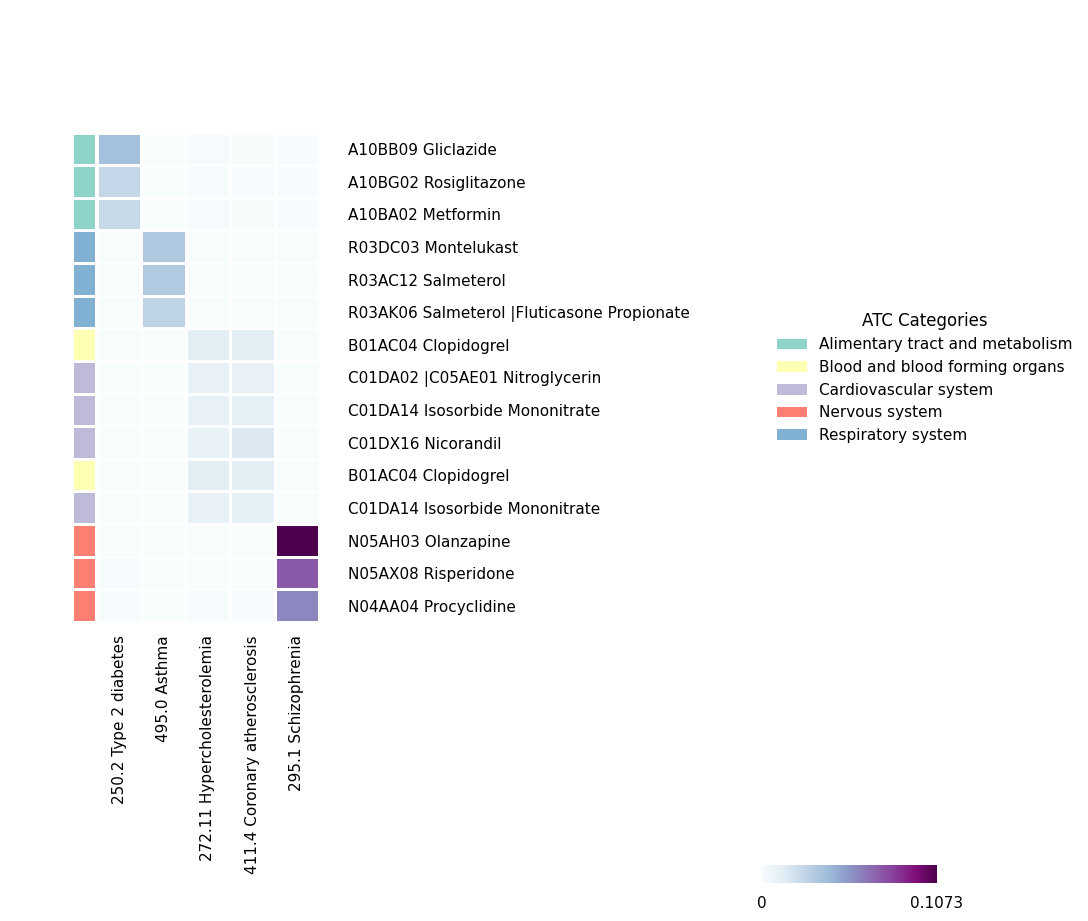

In [ ]:
# suppress font warnings
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# 1) pick your phenotypes of interest
disease_order = [250.2, 495, 272.11, 411.4, 295.1]
# parse the phecode floats out of the column names
col_prefixes = [float(re.match(r"^(\d+\.\d+)", str(c)).group(1))
                for c in phi_med.columns]
phecode_index = [col_prefixes.index(d) for d in disease_order]

# ----------------------------------------------------------------------------
# EXTRACT TOP-3 ICD FOR PHECODE
# ----------------------------------------------------------------------------
# 2) slice out just those phenotypes
phenotypes_df = phi_med.iloc[:, phecode_index]

# 3) find the top 3 meds per phenotype
top_med_indices = []
for col in phenotypes_df.columns:
    top3 = phenotypes_df[col].nlargest(3).index.tolist()
    top_med_indices.extend(top3)

heatmap_df = phenotypes_df.loc[top_med_indices]

# 4) build your ATC‐chapter colors
def first_letter(code): return code[0].upper()
atc_map = {
    'A': 'Alimentary tract and metabolism',
    'B': 'Blood and blood forming organs',
    'C': 'Cardiovascular system',
    'D': 'Dermatologicals',
    'G': 'Genito-urinary system and sex hormones',
    'H': 'Systemic hormonal preparations, excluding sex hormones and insulins',
    'J': 'Antiinfectives for systemic use',
    'L': 'Antineoplastic and immunomodulating agents',
    'M': 'Musculo-skeletal system',
    'N': 'Nervous system',
    'P': 'Antiparasitic products, insecticides and repellents',
    'R': 'Respiratory system',
    'S': 'Sensory organs',
    'V': 'Various'
}
used_chapters = sorted({
    atc_map[first_letter(lbl)] for lbl in heatmap_df.index
})
palette = sns.color_palette("Set3", n_colors=len(used_chapters))
chapter_to_color = dict(zip(used_chapters, palette))

row_colors = pd.Series(
    [chapter_to_color[atc_map[first_letter(lbl)]]
     for lbl in heatmap_df.index],
    index=heatmap_df.index
)

# ----------------------------------------------------------------------------
# PLOT THE CLUSTERMAP USING AVAILABLE CODE
# ----------------------------------------------------------------------------
# 5)
sns.set_context("notebook", font_scale=1)
cg = sns.clustermap(
    heatmap_df,
    cmap="BuPu",
    figsize=(7, 9),
    linewidths=1, linecolor='white',
    row_cluster=False, col_cluster=False,
    row_colors=row_colors,
    colors_ratio=(0.08, 0.03),
    cbar_kws={
        'orientation': 'horizontal',
        'shrink': 0.25,
        'pad': 0.01
    },
    cbar_pos=(1.1, 0.01, 0.25, 0.02)
)

# 6) nudge the row‐color bar back up against the heatmap
rc_ax, hm_ax = cg.ax_row_colors, cg.ax_heatmap
rc_pos, hm_pos = rc_ax.get_position(), hm_ax.get_position()
rc_ax.set_position([
    hm_pos.x0 - rc_pos.width - 0.001,
    rc_pos.y0,
    rc_pos.width,
    rc_pos.height
])
rc_ax.xaxis.set_ticks_position('none')

# 7) rebuild a single legend on the heatmap
from matplotlib.patches import Patch
handles = [Patch(facecolor=chapter_to_color[c], label=c)
           for c in used_chapters]
cg.ax_heatmap.legend(
    handles=handles,
    title="ATC Categories",
    bbox_to_anchor=(3, 0.5),
    loc="center left",
    frameon=False
)

# 8) style the colorbar & axes
cax = cg.cax
m = heatmap_df.values.max()
cax.set_xticks([0, m])
cax.set_xticklabels(['0', f'{m:.4f}'])
cax.xaxis.set_ticks_position('none')

ax = hm_ax
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.tick_params(axis='y', left=False, pad=15)
plt.show()

### Step by step on how to generate synthetic data using the two matrices:
- Using Dirichlet to randomly generate N samples to form a Patient x PheCode matrix.
- Matrix factorization to get the disease/med/operation probabilities for each patients.

- Calculate the token counts (the average disease count per patient) using poisson distribution.

- Based on generative procedure, perform multinomial distribution to randomize the number of diseases and diseases type for the patients.

In [ ]:
# Number of samples that we want to use, for example n = 4000
n = 4000
N, K = n, phi_icd.shape[1]      # phi.shape = (D, K)
alpha = np.ones(K)              # symmetric Dirichlet

# theta: N x K matrix, rows sum to 1
theta = np.random.dirichlet(alpha, size=N)
theta.shape

(4000, 1213)

In [ ]:
np.random.seed(2025)

In [ ]:
def generate_synthetic_data_joint(
    theta,
    phi_icd,
    phi_med,
    phi_opcs,
    mean_tokens_icd=15,
    mean_tokens_med=30,
    mean_tokens_opcs=12,
    random_seed=42):
    # 1) Build joint phi to consider co-occurence between modalities
    phi_w_icd   = phi_icd   * mean_tokens_icd
    phi_w_med   = phi_med   * mean_tokens_med
    phi_w_opcs  = phi_opcs  * mean_tokens_opcs

    phi_joint   = pd.concat([phi_w_icd, phi_w_med, phi_w_opcs], axis=0)
    prob_joint  = theta.dot(phi_joint.to_numpy().T)
    prob_joint /= prob_joint.sum(axis=1, keepdims=True)

# now one multinomial with total = sum of means
    total_mean = mean_tokens_icd + mean_tokens_med + mean_tokens_opcs
    samples     = [np.random.multinomial(
                       np.random.poisson(total_mean),
                       prob_joint[i]
                   ) for i in range(N)]
    binary  = (np.array(samples) > 0).astype(int)  # N × D_total

    # 5) Wide → long
    df_wide = pd.DataFrame(binary, columns=phi_joint.index)
    df_wide["SUBJECT_ID"] = df_wide.index
    df_long = (
        df_wide
        .melt(id_vars="SUBJECT_ID", var_name="code", value_name="presence")
        .query("presence == 1")
        .drop(columns="presence")
    )
    df_freq = (
        df_long
        .value_counts(subset=["SUBJECT_ID","code"])
        .reset_index(name="frequency")
    )

    # 6) Split by modality
    icd_codes  = set(phi_icd.index)
    med_codes  = set(phi_med.index)
    opcs_codes = set(phi_opcs.index)

    synthetic_icd  = df_freq[df_freq["code"].isin(icd_codes)].reset_index(drop=True)
    synthetic_med  = df_freq[df_freq["code"].isin(med_codes)].reset_index(drop=True)
    synthetic_opcs = df_freq[df_freq["code"].isin(opcs_codes)].reset_index(drop=True)

    return synthetic_icd, synthetic_med, synthetic_opcs


synthetic_icd_n, synthetic_med_n, synthetic_opcs_n = generate_synthetic_data_joint(
    theta,
    phi_icd,
    phi_med,
    phi_opcs,
    mean_tokens_icd=15,
    mean_tokens_med=30,
    mean_tokens_opcs=15
)

In [ ]:
# Merge the phecode using ICD10 and PheCode mapping
icd_mapping = pd.read_csv("phecode_icd10.csv")
synthetic_icd_n['code'] = synthetic_icd_n['code'].str.split(' ').str[0]
synthetic_icd_n = synthetic_icd_n.merge(icd_mapping, left_on='code', right_on = 'ICD10')
synthetic_icd_n = synthetic_icd_n[['SUBJECT_ID','code','PheCode', 'frequency']]
synthetic_icd_n.head()

,SUBJECT_ID,code,PheCode,frequency
0,0,A69.9,130.0,1
1,3999,G82.1,344.0,1
2,3999,I08.3,394.0,1
3,3999,J93.0,506.0,1
4,3999,C48.0,159.4,1


In [ ]:
synthetic_med_n.head()

,SUBJECT_ID,code,frequency
0,0,A01AC01 Triamcinolone,1
1,0,A06AA02 Docusate,1
2,0,A07DA53 Loperamide |Simethicone,1
3,0,A08AA10 Sibutramine,1
4,0,A11CA Vitamin A,1


In [ ]:
synthetic_opcs_n.head()

,SUBJECT_ID,code,frequency
0,3999,Z87.2 Ligament of joint,1
1,0,A52.9 Unspecified therapeutic epidural injection,1
2,0,A53.4 Creation of lumboperitoneal shunt,1
3,0,A66.1 Tarsal tunnel release,1
4,0,B16.3 Exploration of parathyroid gland,1


In [ ]:
synthetic_icd_n.to_csv("data/synthetic_icd.csv", index=False)
synthetic_med_n.to_csv("data/synthetic_med.csv", index=False)
synthetic_opcs_n.to_csv("data/synthetic_opcs.csv", index=False)

# 3. Run MixEHR-SAGE

MixEHR-SAGE improves over classic topic model in two aspects:

* Improvement 1: use PheWAS-guidance about expert-defined phenotypes to learn meaningful disease topics
* Improvement 2: includes multiple data types to learn multi-modal disease topics


Outputs of MixEHR-SAGE model:

*   Disease topic representation: For each data type, the disease topic is a distrubtion of words (ICD, medications,...)
*   Patient-topic proportion: Each patient has a distribution of disease topics, indicating disease risk scores




## Step 1: Process Dataset and Extract Seeds


### Prepare data

The EHR data is located in the `./data` directory.

* **Mandatory ICD code**.
Headers:, ICD10, Phecode, Freq


| SUBJECT_ID | ICD10  | Phecode | Freq |
|------------|-------|---------|------|
| 53192      | J45 | 495.10  | 1    |
| 27098      | J43 | 494.00  | 2    |
| ...        | ...   | ...     | ...  |

* **Any other types** as complementary information, such as medication.


| SUBJECT_ID | ATC   | Freq |
|------------|-------|------|
| 7981      | A10B | 1    |
| 12080      | C10 | 2    |
| ...        | ...   | ...  |


In [ ]:
!python run_MixEHR.py

Running: /usr/bin/python3 -W ignore corpus.py process -n 150 ./data/ ./store/
export icd modality
       SUBJECT_ID   code  PheCode  frequency
0               0  A69.9    130.0          1
1            3999  G82.1    344.0          1
2            3999  I08.3    394.0          1
3            3999  J93.0    506.0          1
4            3999  C48.0    159.4          1
...           ...    ...      ...        ...
45429           0  I84.2    455.0          1
45430           0  E10.8    250.1          1
45431           0  E14.4      NaN          1
45432           0    F10    316.0          1
45433           0  C15.5    150.0          1

[45434 rows x 4 columns]
3577 3530 1376
export med modality
export opcs modality
finish exporting mapping
read multi-modal EHR data
0 icd
100.0000  - document(0), word(3267): 100% 45434/45434 [00:19<00:00, 2335.26it/s]
1 med
100.0000  - document(0), word(613): 100% 95242/95242 [00:40<00:00, 2329.96it/s]
2 opcs
100.0000  - document(0), word(1963): 100% 85529/8

## Step 2: Evaluation
The outputs are saved at ./results/, we can evaluate the topic interpretability and phenotype prediction.

We can plot the heatmap by showing the top 3 code for each topic for all three modalities

You can play around with the disease phecode categories.

Let's start with ICD modality:

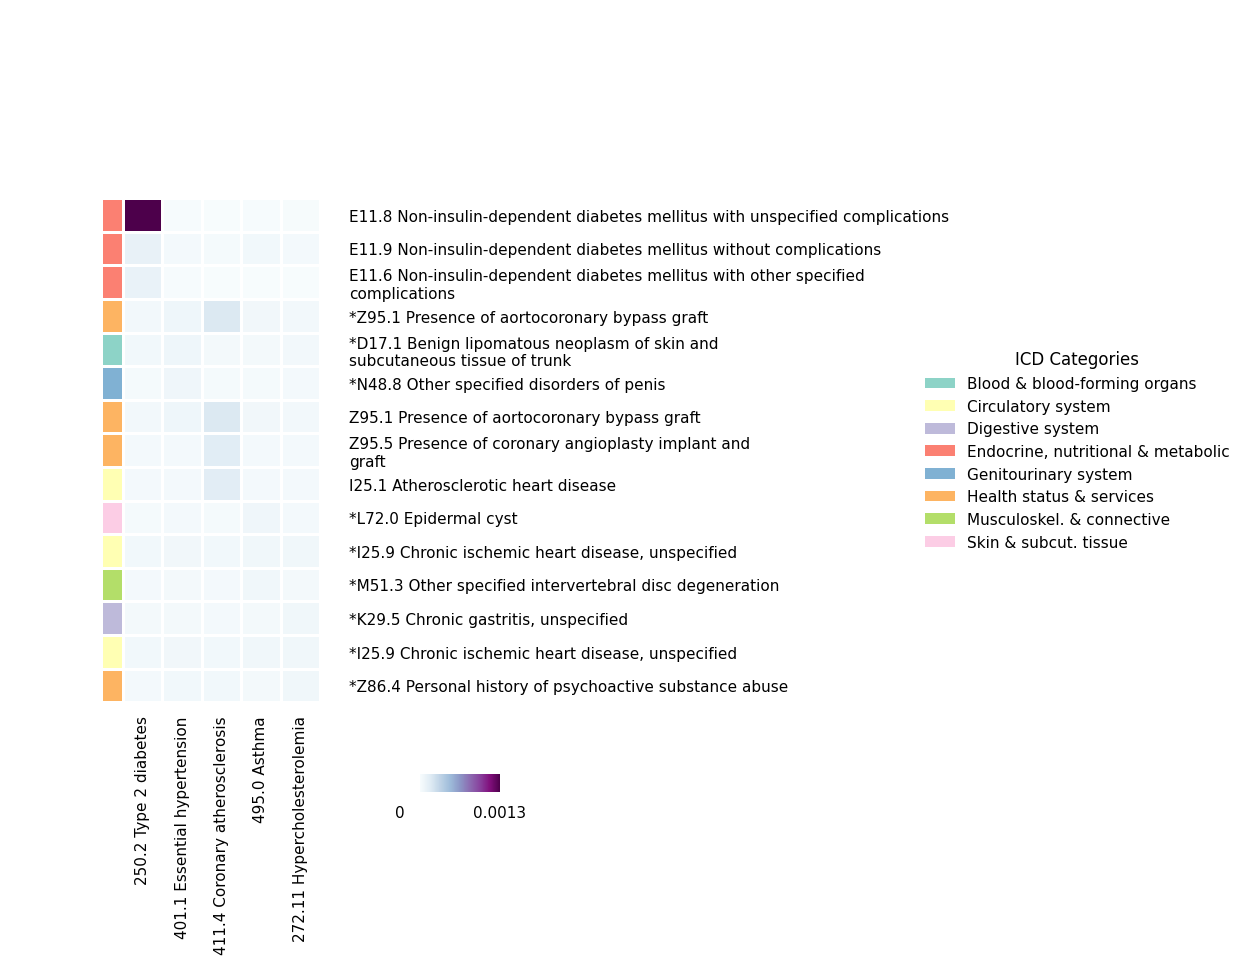

In [ ]:
# ----------------------------------------------------------------------------
# SELECT THE DISEASE OF INTEREST
# ----------------------------------------------------------------------------

disease_order = [250.2,401.1,411.4,495,250.1]

# ----------------------------------------------------------------------------
# READ FILES
# ----------------------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
exp_n = torch.load("results/toy_exp_n_icd_4.pt", map_location=device)
exp_n = exp_n.cpu().detach().numpy()
V, K = exp_n.shape
beta = 0.1
phi_r = (beta + exp_n) / (beta * V + exp_n.sum(axis=1, keepdims=1))
phi_r = phi_r / phi_r.sum(axis=0, keepdims=1)  # normalization over V for each topic

phecode_ids = pkl.load(open("mapping/phecode_ids.pkl", "rb"))
pheno_meaning = pd.read_csv("mapping/phecode_definitions1.2.csv")
icd_name = pkl.load(open("mapping/icd_vocab_ids.pkl", "rb"))

# First mapping (from CSV file)
icd_mapping = pd.read_csv("mapping/allvalid2020 (detailed_titles_headings).csv")
icd_mapping = icd_mapping.iloc[:, [1, 2]].dropna()
icd_mapping.columns = icd_mapping.iloc[0]
icd_mapping = icd_mapping.iloc[1:].reset_index(drop=True)
icd_mapping.columns.name = None
icd_mapping['Code_nodot'] = icd_mapping['Code'].str.replace('.', '')
second_icd_mapping = pd.read_csv("mapping/icd10_definition_coding19.tsv", delimiter='\t')

icd_meaning_dict_first  = dict(zip(icd_mapping['Code'], icd_mapping['ICD Title']))
icd_meaning_dict_second = dict(zip(second_icd_mapping['coding'], second_icd_mapping['meaning']))

inv_phecode_ids = {v: k for k, v in phecode_ids.items()}
inv_icd_ids     = {v: k for k, v in icd_name.items()}
token           = pkl.load(open("mapping/tokenized_phecode_icd.pkl", "rb"))

def map_icd_code(icd_code):
    if icd_code in icd_meaning_dict_first:
        return icd_meaning_dict_first[icd_code], True
    elif icd_code.replace('.', '') in icd_meaning_dict_second:
        return icd_meaning_dict_second[icd_code.replace('.', '')], False
    else:
        return icd_code, False

pheno_meaning_dict = dict(zip(pheno_meaning['phecode'], pheno_meaning['phenotype']))
icd_meaning_list = []
for i in range(V):
    icd_code = str(inv_icd_ids[i])
    mapped, first = map_icd_code(icd_code)
    mapped = mapped.strip()
    if first:
        code_r = icd_mapping[icd_mapping['Code']==icd_code]['Code'].iloc[0]
        icd_meaning_list.append(f"{code_r} {mapped}")
    else:
        icd_meaning_list.append(f"{mapped}")

df_full = pd.DataFrame(phi_r)
pheno_meaning_list = []
for i in range(K):
    pheno_meaning_list.append(f"{inv_phecode_ids[i]} {pheno_meaning_dict[inv_phecode_ids[i]]}")

df_full.columns = pheno_meaning_list
df_full.index   = icd_meaning_list

phecode_index = []
for i in disease_order:
    phecode_index.append(phecode_ids[i])

# 1) Your ICD-10 chapter map by first letter
icd10_chapter_map = {
    'A':'Infectious & parasitic','B':'Infectious & parasitic',
    'C':'Neoplasms','D':'Blood & blood-forming organs',
    'E':'Endocrine, nutritional & metabolic',
    'F':'Mental & behavioural','G':'Nervous system',
    'H':'Eye, ear & mastoid','I':'Circulatory system',
    'J':'Respiratory system','K':'Digestive system',
    'L':'Skin & subcut. tissue','M':'Musculoskel. & connective',
    'N':'Genitourinary system','O':'Pregnancy & childbirth',
    'P':'Perinatal conditions','Q':'Congenital malformations',
    'R':'Symptoms & signs','S':'Injury & poisoning',
    'T':'Injury & poisoning','V':'External causes',
    'W':'External causes','X':'External causes',
    'Y':'External causes','Z':'Health status & services',
    'U':'Special purposes'
}

# ----------------------------------------------------------------------------
# EXTRACT TOP-3 ICD FOR PHECODE
# ----------------------------------------------------------------------------
phenotypes_df = df_full.iloc[:, phecode_index]

top_icd_indices = []
tuples = []
for col in phenotypes_df.columns:
    top3 = phenotypes_df[col].nlargest(3).index.tolist()
    top_icd_indices.extend(top3)
    for icd in top3:
        tuples.append((col.split()[0], icd.split()[0]))

heatmap_df = phenotypes_df.loc[top_icd_indices]

def first_letter(label):
    return label.strip().split()[0][0].upper()

used_chapters = {
    icd10_chapter_map[first_letter(lbl)]
    for lbl in heatmap_df.index
}

# 2) Generate a palette sized to exactly len(used_chapters)
palette = sns.color_palette("Set3", n_colors=len(used_chapters))
used_chapters = sorted(used_chapters)
chapter_to_color = dict(zip(used_chapters, palette))

# 3) Build your row_colors Series
row_colors = pd.Series(
    [chapter_to_color[icd10_chapter_map[first_letter(lbl)]]
     for lbl in heatmap_df.index],
    index=heatmap_df.index
)

sns.set_context("notebook", font_scale=1)
# 5) Draw your clustermap
cg = sns.clustermap(
    heatmap_df, cmap="BuPu", figsize=(4,9),
    linewidths=1, linecolor='white',
    row_cluster=False, col_cluster=False,
    row_colors=row_colors,
    colors_ratio=(0.08,0.03),
    cbar_kws={'orientation':'horizontal',
              'shrink':0.25, 'pad':0.01},
    cbar_pos=(1.1,0.01,0.25,0.02)
)

rc_ax = cg.ax_row_colors
hm_ax = cg.ax_heatmap
rc_pos, hm_pos = rc_ax.get_position(), hm_ax.get_position()
new_x0 = hm_pos.x0 - rc_pos.width - 0.001
rc_ax.set_position([new_x0, rc_pos.y0, rc_pos.width, rc_pos.height])
rc_ax.xaxis.set_ticks_position('none')

from matplotlib.patches import Patch
handles = [Patch(facecolor=chapter_to_color[ch], label=ch)
           for ch in sorted(used_chapters)]
if cg.ax_col_dendrogram.get_legend():
    cg.ax_col_dendrogram.get_legend().remove()

cg.ax_heatmap.legend(
    handles=handles, title="ICD Categories",
    bbox_to_anchor=(4,0.5), loc="center left",
    frameon=False
)

cax = cg.cax
max_val = heatmap_df.values.max()
cax.set_xticks([0, max_val])
cax.set_xticklabels(['0', f'{max_val:.4f}'])
cax.xaxis.set_ticks_position('none')

ax = cg.ax_heatmap
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.tick_params(axis='y', left=False, pad=15)
label_match = []
inv_token = {}
for k, vals in token.items():
    for v in vals:
        inv_token.setdefault(v, k)
for phecode_str, icd_str in tuples:
    pid = phecode_ids[float(phecode_str)] # phecode ids index
    # convert icd_str back to your integer index:
    icd_idx = icd_name[icd_str]
    label_match.append(icd_idx in token[pid])
labels = ax.get_yticklabels()
new_texts = []

for lbl, match in zip(labels, label_match):
    txt = lbl.get_text()
    new_texts.append(("*"+txt) if not match else txt)

def wrap_label(label, max_words=8):
    words = label.split()
    if len(words)>max_words:
        return " ".join(words[:max_words])+"\n"+" ".join(words[max_words:])
    return label

wrapped_texts = [wrap_label(txt,7) for txt in new_texts]
ax.set_yticklabels(wrapped_texts, rotation=0)
plt.show()


Exercise: Try plot the heatmap for other modalities, category dictionary is given in each code block.

In [ ]:
# ----------------------------------------------------------------------------
# READ RESULT FILES
# ----------------------------------------------------------------------------
exp_n_med = torch.load("results/toy_exp_n_med_4.pt", map_location=device)
exp_n_med = exp_n_med.cpu().detach().numpy()
V, K = exp_n_med.shape
beta = 0.1
phi_r_med = (beta + exp_n_med) / (beta*V + exp_n_med.sum(axis=1, keepdims=1))
phi_r_med = phi_r_med / phi_r_med.sum(axis=0, keepdims=1) # normal
inv_phecode_ids = {v: k for k, v in phecode_ids.items()}
med_ids = pkl.load(open("mapping/med_vocab_ids.pkl", "rb"))
inv_med_ids = {v: k for k, v in med_ids.items()}
df_full_med = pd.DataFrame(phi_r_med)
pheno_meaning_list = []
med_meaning_list = []
for i in range(K):
    pheno_meaning_list.append(str(inv_phecode_ids[i]) + ' ' + pheno_meaning_dict[inv_phecode_ids[i]])
for i in range(V):
    med_meaning_list.append(str(inv_med_ids[i]) )
    # pheno_meaning_list.append(pheno_meaning_dict[inv_phecode_ids[i]])
df_full_med.columns = pheno_meaning_list
df_full_med.index = med_meaning_list
atc_first_level_map = {
    'A': 'Alimentary tract and metabolism',
    'B': 'Blood and blood forming organs',
    'C': 'Cardiovascular system',
    'D': 'Dermatologicals',
    'G': 'Genito-urinary system and sex hormones',
    'H': 'Systemic hormonal preparations, excluding sex hormones and insulins',
    'J': 'Antiinfectives for systemic use',
    'L': 'Antineoplastic and immunomodulating agents',
    'M': 'Musculo-skeletal system',
    'N': 'Nervous system',
    'P': 'Antiparasitic products, insecticides and repellents',
    'R': 'Respiratory system',
    'S': 'Sensory organs',
    'V': 'Various'
}

# ----------------------------------------------------------------------------
# EXTRACT TOP 3 TOPICS
# ----------------------------------------------------------------------------


# ----------------------------------------------------------------------------
# PLOT THE CLUSTERMAP USING AVAILABLE CODE
# ----------------------------------------------------------------------------


In [ ]:
exp_n_opcs = torch.load("results/toy_exp_n_opcs_4.pt", map_location=device)
exp_n_opcs = exp_n_opcs.cpu().detach().numpy()
V, K = exp_n_opcs.shape
beta = 0.1
phi_r_opcs = (beta + exp_n_opcs) / (beta*V + exp_n_opcs.sum(axis=1, keepdims=1))
phi_r_opcs = phi_r_opcs / phi_r_opcs.sum(axis=0, keepdims=1)

inv_phecode_ids = {v: k for k, v in phecode_ids.items()}
opcs_ids = pkl.load(open("mapping/opcs_vocab_ids.pkl", "rb"))
inv_opcs_ids = {v: k for k, v in opcs_ids.items()}
opcs_meaning = pd.read_csv("opcs_definition.tsv", delimiter = '\t')

pheno_meaning_dict = dict(zip(pheno_meaning['phecode'], pheno_meaning['phenotype']))
df_full_opcs = pd.DataFrame(phi_r_opcs)
pheno_meaning_list = []
opcs_meaning_list = []
for i in range(K):
    pheno_meaning_list.append(str(inv_phecode_ids[i]) + ' ' + pheno_meaning_dict[inv_phecode_ids[i]])
for i in range(V):
    opcs_meaning_list.append(inv_opcs_ids[i])
    # pheno_meaning_list.append(pheno_meaning_dict[inv_phecode_ids[i]])
df_full_opcs.columns = pheno_meaning_list
df_full_opcs.index = opcs_meaning_list

phenotypes_df = df_full_opcs.iloc[:, phecode_index]

# Find the top 5 genes for each phenotype and collect their indices.
top_genes_indices = []
for col in phenotypes_df.columns:
    top_genes = phenotypes_df[col].nlargest(3).index
    top_genes_indices.extend(top_genes)

heatmap_df = phenotypes_df.loc[top_genes_indices,].drop_duplicates()

# 1) Your ICD-10 chapter map by first letter
opcs4_chapter_map = {
    'A': 'Nervous System',
    'B': 'Endocrine System and Breast',
    'C': 'Eye',
    'D': 'Ear',
    'E': 'Respiratory Tract',
    'F': 'Mouth',
    'G': 'Upper Digestive System',
    'H': 'Lower Digestive System',
    'J': 'Other Abdominal Organs, Principally Digestive',
    'K': 'Heart',
    'L': 'Arteries and Veins',
    'M': 'Urinary',
    'N': 'Male Genital Organs',
    'P': 'Lower Female Genital Tract',
    'Q': 'Upper Female Genital Tract',
    'R': 'Female Genital Tract Associated with Pregnancy, Childbirth and the Puerperium',
    'S': 'Skin',
    'T': 'Soft Tissue',
    'U': 'Diagnostic Imaging, Testing and Rehabilitation',
    'V': 'Bones and Joints of Skull and Spine',
    'W': 'Other Bones and Joints',
    'X': 'Miscellaneous Operations',
    'Y': 'Subsidiary Classification of Methods of Operation',
    'Z': 'Subsidiary Classification of Sites of Operation',
    'O': 'Overflow codes'
}

# ----------------------------------------------------------------------------
# EXTRACT TOP 3 TOPICS
# ----------------------------------------------------------------------------


# ----------------------------------------------------------------------------
# PLOT THE CLUSTERMAP USING AVAILABLE CODE
# ----------------------------------------------------------------------------


[True, True, True, False, False, False, True, True, True, False, False, False, False, False, False]


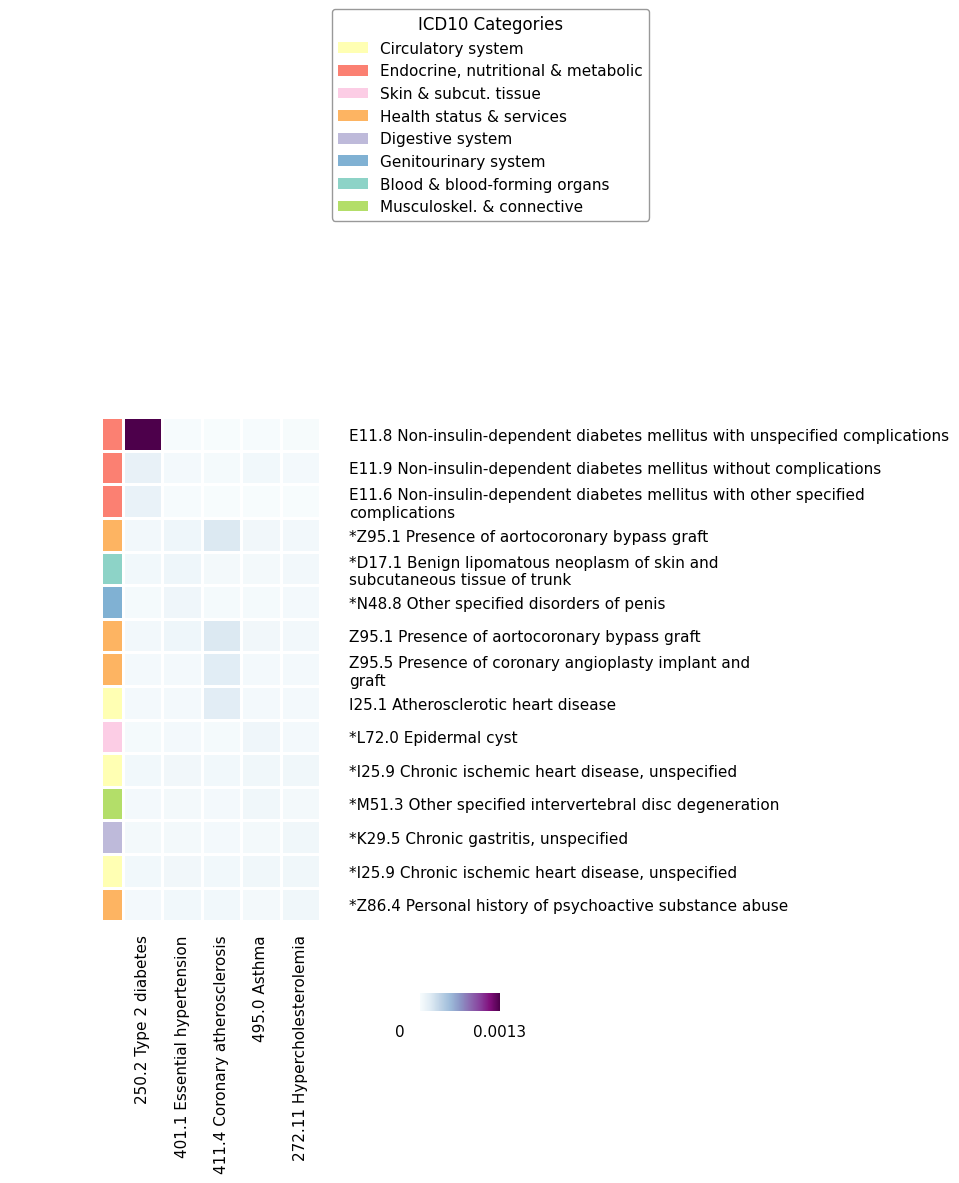

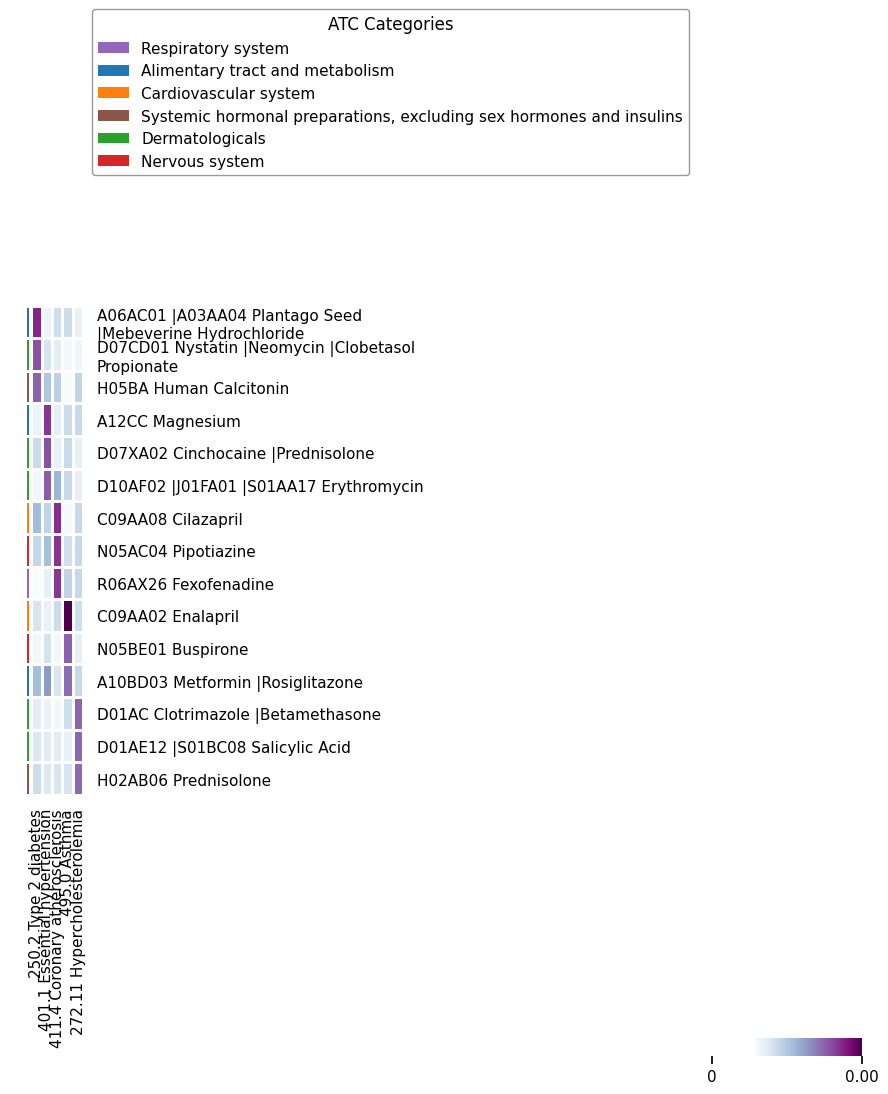

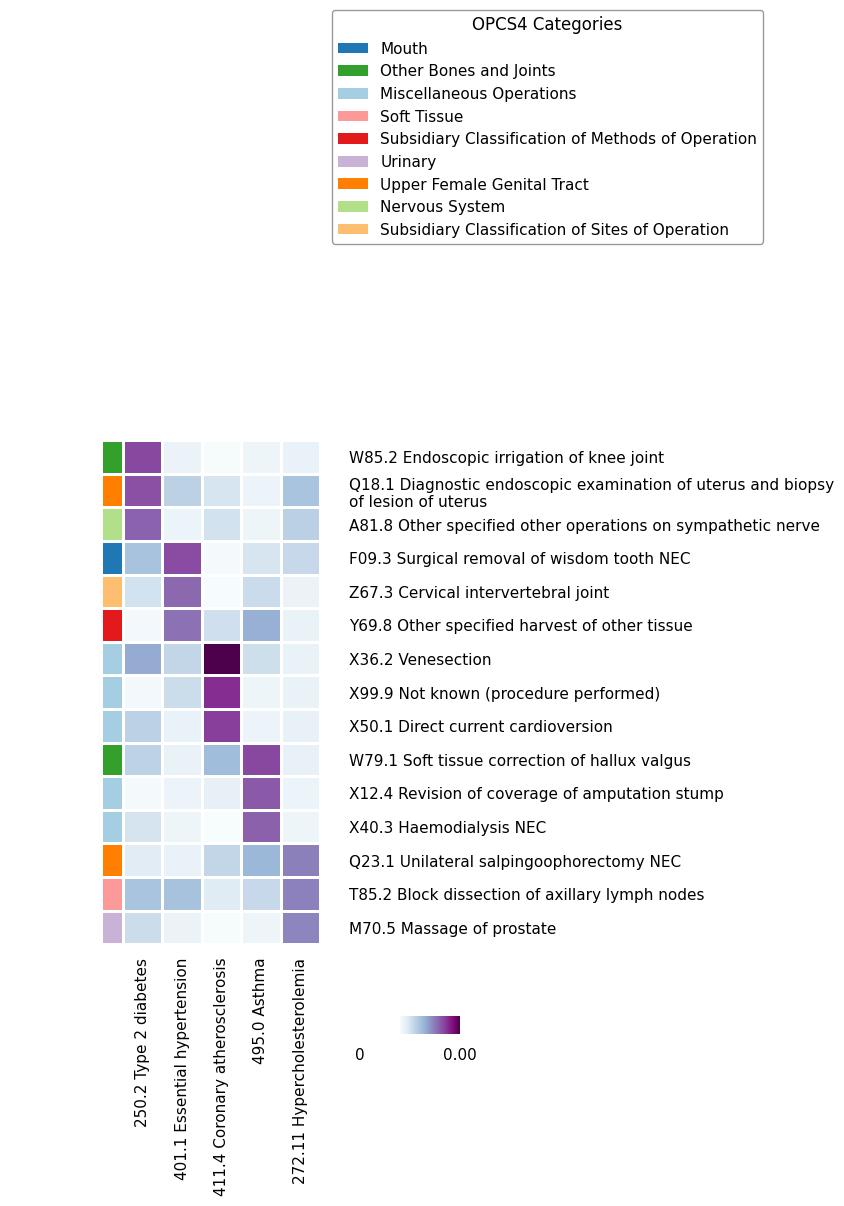

<Figure size 640x480 with 0 Axes>

In [ ]:
# Solution for the above exercise are condensed into the plotting.py file
# Feel free to consult the detail within the code and change the disease accordingly
# PheCode can be found using PheWAS: https://phewascatalog.org/phewas/#phe12
# all three modalities have been aggregated into one python file
%run plotting.py --disease_order "250.2,401.1,411.4,495,272.11"

#### Exercise: try it yourself plot the disease of interests

In [ ]:
# try running plotting.py
#%run plotting.py --disease_order

# Genotype Integration: 1000 Genomes + GWAS Prep - If time allows

In this section, we demonstrate how to integrate synthetic phenotypes with real genotype data from the 1000 Genomes Project. This enables downstream genome-wide association studies (GWAS) using our simulated phenotypes derived from MixEHR-SAGE.

### 4.1 Overview of 1000 Genomes Dataset

- Publicly available dataset representing diverse human populations.
- Contains ~2,500 individuals from 26 global populations.
- For this tutorial, we focus on the **European (EUR)** subset to match the population profile of UK Biobank. (378 individuals)

The dataset in bed/bim/fam version can be downloaded through: https://zenodo.org/records/6614170#:~:text=Genotype%20data%20for%20individuals%20from,against%20GEUVADIS%20gene%20expression%20phenotypes.


In [ ]:
!wget https://zenodo.org/records/6614170/files/1000G_EUR.fam
!wget https://zenodo.org/records/6614170/files/1000G_EUR.bed
!wget https://zenodo.org/records/6614170/files/1000G_EUR.bim

--2025-06-13 03:04:01--  https://zenodo.org/records/6614170/files/1000G_EUR.fam
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9557 (9.3K) [application/octet-stream]
Saving to: ‘1000G_EUR.fam.1’

1000G_EUR.fam.1     100%[===================>]   9.33K  --.-KB/s    in 0.02s   

2025-06-13 03:04:02 (526 KB/s) - ‘1000G_EUR.fam.1’ saved [9557/9557]

--2025-06-13 03:04:02--  https://zenodo.org/records/6614170/files/1000G_EUR.bed
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231387159 (221M) [application/octet-stream]
Saving to: ‘1000G_EUR.bed.1’

1000G_EUR.bed.1     100%[===================>] 220.67M  16.6MB/s    in 14s     

2025-06-13 03:04:17 (15.4 MB/s) - ‘100

In [ ]:
# ⚠️ NOTE (12/06/2025): This hack might be necessary to run this notebook
# on Google Colab. It removes pre-installed dependencies that are
# incompatible with magenpy/viprs. You don't need to run this locally.

# You will need to rerun this on Colab again to install the packages
!pip install magenpy > /dev/null 2>&1

In [ ]:
import magenpy as mgp
from scipy.special import softmax

sim = mgp.PhenotypeSimulator(mgp.tgp_eur_data_path(), h2=0.8, pi=0.05)

n_phenotypes = 10
phenos = []

for _ in range(n_phenotypes):
    sim.simulate()
    phenos.append(sim.sample_table.phenotype.reshape(-1, 1))

phenos = np.concatenate(phenos, axis=1)
phenos = softmax(phenos, axis=1)

phenos, phenos.shape

Generating polygenic scores: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


(array([[0.09394927, 0.09950595, 0.06486977, ..., 0.03663308, 0.03368409,
         0.02651928],
        [0.0964175 , 0.19608364, 0.18717039, ..., 0.06149498, 0.02527247,
         0.01898689],
        [0.14811748, 0.14221917, 0.07461404, ..., 0.03325661, 0.085056  ,
         0.0531675 ],
        ...,
        [0.12831356, 0.06250474, 0.38611769, ..., 0.05058161, 0.04832252,
         0.03688738],
        [0.14924769, 0.12226355, 0.24573975, ..., 0.03200749, 0.03687102,
         0.00845465],
        [0.07677856, 0.10185084, 0.2387506 , ..., 0.0812253 , 0.17714653,
         0.0314018 ]]),
 (378, 10))

In [ ]:
patient_info = sim.to_phenotype_table()[['FID', 'IID']]
patient_info.head()

,FID,IID
0,HG00096,HG00096
1,HG00097,HG00097
2,HG00099,HG00099
3,HG00100,HG00100
4,HG00101,HG00101


Incorporate the

In [ ]:
# Since we synthesized 10 topics using magenpy, we can select 10 clinically relevant disease topics
disease = [250.2, 250.1, 411.4, 401.1, 272.11, 290, 495, 204, 562.1, 411.2]
indices = []
for i in disease:
  idx = phecode_ids[i]
  indices.append(idx)
indices

[269, 773, 55, 453, 607, 978, 147, 630, 376, 271]

In [ ]:
phi_of_interest = phi_r[:,indices]

In [ ]:
phi_of_interest.shape

(3577, 10)

In [ ]:
prob = phenos.dot(phi_of_interest.T)    # → shape (N, D)
prob /= prob.sum(axis=1, keepdims=True)  # just in case of drift
prob

array([[0.00028318, 0.00027706, 0.00027715, ..., 0.00027105, 0.00026987,
        0.00026759],
       [0.00028491, 0.00027685, 0.00027693, ..., 0.00027077, 0.00026966,
        0.00026738],
       [0.00028378, 0.00027696, 0.00027727, ..., 0.00027095, 0.0002695 ,
        0.00026722],
       ...,
       [0.00028434, 0.00027664, 0.00027685, ..., 0.00027053, 0.00026931,
        0.00026703],
       [0.00028457, 0.0002771 , 0.00027742, ..., 0.0002708 , 0.00026963,
        0.00026735],
       [0.00028359, 0.00027637, 0.00027635, ..., 0.00027129, 0.00026933,
        0.00026705]])

In [ ]:
# Download Plink 1.9
!wget -q https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20210606.zip
!unzip -q plink_linux_x86_64_20210606.zip
!chmod +x plink

replace plink? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace toy.ped? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace toy.map? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace prettify? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


### 4.2 PCA and Covariate Control

- Compute **Principal Components (PCs)** from genotype data using PLINK:

- Description of key options:

    --bfile: Specifies the base name of the PLINK binary genotype dataset.

    --Computes the top 10 principal components.

    --out: Sets the prefix for output files.

In [ ]:
!./plink \
  --bfile '1000G_EUR' \
  --pca 10 \
  --out 1000G_EUR_pca

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000G_EUR_pca.log.
Options in effect:
  --bfile 1000G_EUR
  --out 1000G_EUR_pca
  --pca 10

54231 MB RAM detected; reserving 27115 MB for main workspace.
1836406 variants loaded from .bim file.
503 people (240 males, 263 females) loaded from .fam.
Using up to 11 threads (change this with --threads).
Before main variant filters, 503 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%70%71%72%73%74%

In [ ]:
fam = pd.read_csv("1000G_EUR.fam", delimiter='\t', header=None)
pcs = pd.read_csv("1000G_EUR_pca.eigenvec", delimiter = ' ', header=None)

covar = pd.DataFrame()
covar[0] = fam[0]  # FID
covar[1] = fam[1]  # IID
covar[2] = fam[4].replace({1: 1, 2: 0})  # SEX
covar = pd.concat([covar, pcs.iloc[:, 2:]], axis=1)  # Add PCs
covar.to_csv("covariates.txt", sep=' ', index=False, header=False)

### 4.3 Aligning Individuals (Only for dispaly purporses)

- Previously, we randomly sampled 4,000 individuals’ phenotypes from MixEHR-SAGE synthetic θ.
- To simulate GWAS realistically, we **randomly select 1:1 mapping individuals** between these phenotypes and the 1000 Genomes individuals.
- Using the first disease phecode as example (Type 2 Diabetes, 250.2)



In [ ]:
pheno_i = []
for i in indices:
  icds = token[i]
  new_phi = prob[:,icds].sum(axis = 1)
  pheno_i.append(new_phi)

In [ ]:
phenotype_i = pd.DataFrame({
    'FID': 0,
    'IID': patient_info['IID'],
    'PHENO': pheno_i[0]
})

# Step 5: Save the phenotype data to a tab-delimited text file
phenotype_i.to_csv('synthetic_phenotype_i.txt', sep='\t', index=False, header = None)

In [ ]:
phenotype_i

,FID,IID,PHENO
0,0,HG00096,0.001832
1,0,HG00097,0.001832
2,0,HG00099,0.001906
3,0,HG00100,0.001884
4,0,HG00101,0.002099
...,...,...,...
373,0,NA20815,0.001878
374,0,NA20818,0.002056
375,0,NA20819,0.001873
376,0,NA20826,0.001904


Description of key options:

--bfile: Specifies the base name of the PLINK binary genotype dataset.

--linear: Performs linear regression for a continuous phenotype.

hide-covar: Hides covariate regression coefficients in the output.

--allow-no-sex: Ignores missing sex information in the .fam file.

--maf 0.001: Filters variants with minor allele frequency (MAF) below 0.1%.

--mac 5: Filters variants with minor allele count (MAC) less than 5.

--covar: Specifies a file containing covariates (e.g., sex, PCs).

--pheno: Specifies the file containing synthetic phenotype values.

--threads: Number of CPU threads to speed up computation.

--out: Sets the prefix for output files.

In [ ]:
!./plink --bfile "1000G_EUR" \
       	  --linear hide-covar \
        	--allow-no-sex \
		      --maf 0.001 \
        	--mac 5 \
		      --covar "covariates.txt" \
		      --threads 5 \
		      --pheno "synthetic_phenotype_i.txt"  \
        	--out "plink_1000g_sample"

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink_1000g_sample.log.
Options in effect:
  --allow-no-sex
  --bfile 1000G_EUR
  --covar covariates.txt
  --linear hide-covar
  --mac 5
  --maf 0.001
  --out plink_1000g_sample
  --pheno synthetic_phenotype_i.txt
  --threads 5

54231 MB RAM detected; reserving 27115 MB for main workspace.
1836406 variants loaded from .bim file.
503 people (240 males, 263 females) loaded from .fam.
378 phenotype values present after --pheno.
Using 1 thread.
currently disregard the --threads limit.  If this is problematic, you may want
to recompile against single-threaded BLAS/LAPACK.
--covar: 11 covariates loaded.
Before main variant filters, 503 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%

In [ ]:
summary_stats = pd.read_csv("plink_1000g_sample.assoc.linear", sep='\s+')
summary_stats

,CHR,SNP,BP,A1,TEST,NMISS,BETA,STAT,P
0,1,rs3131972,752721,A,ADD,378,-0.000009,-0.80250,0.4228
1,1,rs12184325,754105,T,ADD,378,0.000002,0.09897,0.9212
2,1,rs3131969,754182,A,ADD,378,-0.000013,-1.05700,0.2914
3,1,rs3131967,754334,T,ADD,378,-0.000013,-1.05700,0.2914
4,1,rs3131962,756604,A,ADD,378,-0.000012,-1.04600,0.2962
...,...,...,...,...,...,...,...,...,...
1642499,22,rs3865764,51185848,G,ADD,378,0.000004,0.21830,0.8273
1642500,22,rs142680588,51193629,G,ADD,378,0.000018,1.24500,0.2140
1642501,22,rs3888396,51211392,C,ADD,378,-0.000008,-0.71140,0.4773
1642502,22,rs2238837,51212875,C,ADD,378,-0.000008,-0.98640,0.3246


### Plot the manhattan plot for T2D

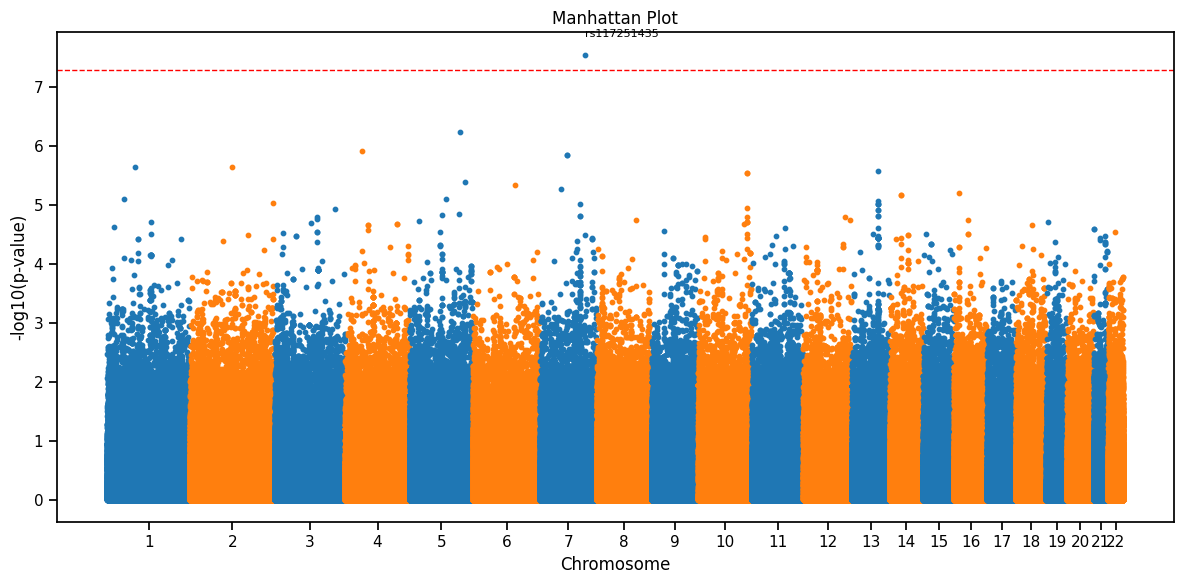

In [ ]:
summary_stats = summary_stats.dropna(subset=['CHR', 'BP', 'P'])

summary_stats = summary_stats.sort_values(['CHR', 'BP'])

# Create a new column for cumulative base-pair position
summary_stats['ind'] = range(len(summary_stats))
summary_stats['-log10(P)'] = -np.log10(summary_stats['P'])

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e']  # Alternate colors for chromosomes
x_labels = []
x_labels_pos = []

# Group data by chromosome
for i, (chr_num, group) in enumerate(summary_stats.groupby('CHR')):
    group.plot(kind='scatter', x='ind', y='-log10(P)', color=colors[i % len(colors)], ax=ax, s=10)
    x_labels.append(chr_num)
    x_labels_pos.append((group['ind'].iloc[-1] + group['ind'].iloc[0]) / 2)

# Customize the plot
ax.set_xlabel('Chromosome')
ax.set_ylabel('-log10(p-value)')
ax.set_title('Manhattan Plot')
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(y=-np.log10(5e-8), color='red', linestyle='--', linewidth=1)

# Annotate SNPs with p-value below a threshold (e.g., 5e-8)
significance_threshold = 5e-8
significant_snps = summary_stats[summary_stats['P'] < significance_threshold]

for _, row in significant_snps.iterrows():
    ax.text(row['ind']-0.1, row['-log10(P)'] + 0.3, row['SNP'], fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
significant = summary_stats[summary_stats['P'] < 5e-8]

significant

,CHR,SNP,BP,A1,TEST,NMISS,BETA,STAT,P,ind,-log10(P)
772223,7,rs117251435,129016052,C,ADD,378,0.000148,5.678,2.781000e-08,772082,7.555799


# Practice and exercise afterwards

## Using existing UKB synthetic data.

* https://biobank.ndph.ox.ac.uk/synthetic_dataset/

* Values were randomly generated and the dataset is presented without any warranty of correctness or accuracy. The datasets are therefore not internally consistent – for instance they may contain reports of prostate cancer linked to female participants, medical events after death or dates of disease without corresponding diagnoses.

* tabular/string_fields2.tsv (ICD (41270) and OPCS-4 code (41272))
* tabular/integer_arrays_part2.tsv (Medication code (20003))
* First 3000 individuals of the synthetic dataset is provided in the same github repository (**ukb_synthetic_{icd/med/opcs}.csv**)
* This results are not biologicall meaningful, you can also use the entire dataset to try exploring the size and power of the code.

In [ ]:
# Read the synthetic dataset
# ukb_synthetic_icd
# ukb_synthetic_medication
# ukb_synthetic_opcs

In [ ]:
# Synthetic dataset from UKB

ukb_icd_syn = pd.read_csv("ukb_synthetic_icd.csv")
ukb_med_syn = pd.read_csv("ukb_synthetic_medication.txt")
ukb_opcs_syn = pd.read_csv("ukb_synthetic_opcs.csv")

In [ ]:
# @title
ukb_med_long = ukb_med_syn.melt(
    id_vars=["eid"],
    var_name="field",
    value_name="med_code"
)
atc_mapping = pd.read_csv('atc_mapping.csv')
ukb_med_long = ukb_med_long.merge(atc_mapping, left_on='med_code',right_on ='Coding a')
ukb_med_long = ukb_med_long[['eid', 'Medication ATC code', 'Drug name']]
ukb_med_long

,eid,Medication ATC code,Drug name
0,1000016,R06AB04,Chlorphenamine
1,1000057,N05CD06,Lormetazepam
2,1000151,C08CA09,Lacidipine
3,1000269,A12BA,Potassium
4,1000287,A11CC01,Ergocalciferol
...,...,...,...
37417,1044851,N02AB03,Fentanyl
37418,1044895,C03EA01,Triamterene |Hydrochlorothiazide
37419,1044954,N02AJ06,Acetaminophen |Codeine
37420,1045099,G03FA01,Norethisterone |Estradiol


In [ ]:
# @title
phecode_mapping = pd.read_csv('phecode_icd10.csv')
icd_mapping = phecode_mapping[['ICD10', 'PheCode']]
icd_mapping

,ICD10,PheCode
0,A00,8.00
1,A00.0,8.00
2,A00.1,8.00
3,A00.9,8.00
4,A01,8.00
...,...,...
9500,Z97.3,367.00
9501,Z97.4,389.00
9502,Z99.1,509.80
9503,Z99.2,585.31


In [ ]:
# @title
ukb_icd_long = ukb_icd_syn.melt(
    id_vars=["eid"],
    var_name="field",
    value_name="ICD10"
)
phecode_mapping = pd.read_csv('phecode_icd10.csv')
icd_mapping = phecode_mapping[['ICD10', 'PheCode']]
icd_mapping['ICD10'] = icd_mapping['ICD10'].str.replace('.', '')
ukb_icd_long = ukb_icd_long.merge(icd_mapping, how = 'left')
ukb_icd_long = ukb_icd_long[['eid', 'ICD10', 'PheCode']].dropna(subset=["ICD10"])
ukb_icd_long

,eid,ICD10,PheCode
0,1000016,Z365,NaN
1,1000048,Z365,NaN
2,1000057,Z365,NaN
3,1000059,Z365,NaN
5,1000068,Z365,NaN
...,...,...,...
632973,1000048,T272,1000.0
635972,1000016,Y850,NaN
635973,1000048,R268,350.2
638972,1000016,Z924,NaN


In [ ]:
# @title
ukb_opcs_long = ukb_opcs_syn.melt(
    id_vars=["eid"],
    var_name="field",
    value_name="OPCS4"
)
ukb_opcs_long = ukb_opcs_long[['eid', 'OPCS4']].dropna()
ukb_opcs_long

,eid,OPCS4
0,1000016,G043
1,1000048,G043
2,1000057,G043
3,1000059,G043
5,1000068,G043
...,...,...
342001,1000048,Z182
345000,1000016,T989
345001,1000048,Y524
348000,1000016,F632


The MixEHR-SAGE is built upon an input csv file under data/ukbb_metadata.csv
The csv should be modified based on your column names.

In [ ]:
# @title
ukb_icd_long = ukb_icd_long.rename(columns={"ICD10": "code", 'eid':'SUBJECT_ID'}).drop_duplicates()
ukb_med_long = ukb_med_long.rename(columns={"Medication ATC code": "code", 'eid':'SUBJECT_ID'}).drop_duplicates()
ukb_opcs_long = ukb_opcs_long.rename(columns={"OPCS4": "code", 'eid':'SUBJECT_ID'}).drop_duplicates()
ukb_icd_long.to_csv("data/my_icd_data.csv", index=False)
ukb_med_long.to_csv("data/my_med_data.csv", index=False)
ukb_opcs_long.to_csv("data/my_opcs_data.csv", index=False)
meta_path = "data/ukbb_metadata.csv"
metadata = pd.read_csv(meta_path)

# Remove old rows if they exist
metadata = metadata[~metadata["index"].isin(["icd", "med", "opcs"])]

# Add new rows with updated paths
new_metadata = pd.DataFrame([
    {"index": "icd", "path": "./data/my_icd_data.csv", "word_column": "code"},
    {"index": "med", "path": "./data/my_med_data.csv", "word_column": "code"},
    {"index": "opcs", "path": "./data/my_opcs_data.csv", "word_column": "code"},
])

# Save updated metadata
metadata = pd.concat([metadata, new_metadata], ignore_index=True)
metadata.to_csv(meta_path, index=False)

In [ ]:
!python run_MixEHR.py

Running: /usr/bin/python3 -W ignore corpus.py process -n 150 ./data/ ./store/
export icd modality
        SUBJECT_ID   code  PheCode
0          1000016   Z365      NaN
1          1000048   Z365      NaN
2          1000057   Z365      NaN
3          1000059   Z365      NaN
4          1000068   Z365      NaN
...            ...    ...      ...
198134     1000048   T272   1000.0
198135     1000016   Y850      NaN
198136     1000048   R268    350.2
198137     1000016   Z924      NaN
198138     1000048  M8954      NaN

[198139 rows x 3 columns]
16008 7431 1460
export med modality
export opcs modality
finish exporting mapping
read multi-modal EHR data
0 icd
100.0000  - document(1000048), word(3786): 100% 198139/198139 [01:37<00:00, 2041.88it/s]
1 med
100.0000  - document(1045107), word(95): 100% 36985/36985 [00:15<00:00, 2323.57it/s]
2 opcs
100.0000  - document(1000048), word(7833): 100% 125175/125175 [01:00<00:00, 2076.00it/s]
INFO:__main__:Creating corpus...
INFO:__main__:
        =========